In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from modAL.models import ActiveLearner, BayesianOptimizer
from modAL.acquisition import max_EI, optimizer_EI
import pandas as pd
import utilities as utils

## Active learning in 3D

Varying pipe_D, bend angle and inlet_v to predict $\Delta P$

In [37]:
input_file = 'examples/outputs_3D_random.txt'
rho = 998 # [kg m^-3]
muo = 9.737e-4 # [Pa s]
data = pd.read_csv(input_file, delimiter='\t')

X_raw = np.stack((data['Pipe D'], data['Elbow angle'], data['Inlet V']), axis=-1)
y_raw = np.array(data['Del P/L'].astype('float'))

# Isolate our examples for labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

X_train, y_train, X_pool, y_pool

(array([[7.9e-02, 4.9e+01, 6.0e-03],
        [6.9e-02, 9.2e+01, 7.0e-03],
        [8.4e-02, 4.7e+01, 2.0e-02]]),
 array([0.04964308, 0.09155368, 0.22665419]),
 array([[2.10e-02, 1.00e+00, 1.10e-02],
        [5.50e-02, 9.00e+00, 1.10e-02],
        [4.90e-02, 1.30e+01, 2.00e-02],
        [2.20e-02, 2.00e+01, 2.00e-02],
        [1.00e-02, 4.80e+01, 6.00e-03],
        [1.30e-02, 5.00e+01, 5.00e-03],
        [3.20e-02, 5.30e+01, 2.50e-02],
        [5.30e-02, 5.70e+01, 1.00e-02],
        [1.00e-01, 7.10e+01, 1.10e-02],
        [5.40e-02, 8.30e+01, 2.10e-02],
        [1.40e-02, 8.40e+01, 6.00e-03],
        [8.30e-02, 8.40e+01, 6.00e-03],
        [1.40e-02, 9.30e+01, 1.30e-02],
        [7.50e-02, 9.90e+01, 6.00e-03],
        [6.70e-02, 1.06e+02, 2.50e-02],
        [3.80e-02, 1.11e+02, 1.30e-02],
        [7.50e-02, 1.12e+02, 2.10e-02],
        [2.70e-02, 1.29e+02, 1.80e-02],
        [2.10e-02, 1.31e+02, 8.00e-03],
        [6.70e-02, 1.53e+02, 2.20e-02],
        [6.40e-02, 1.59e+02, 8.00e-03],
 

In [38]:
def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    return np.argmax(std)

kernel = Matern(length_scale=10.0) 
regressor = GaussianProcessRegressor(kernel=kernel)

regressor_3d = BayesianOptimizer(
    estimator=regressor,
    query_strategy=max_EI,
    X_training=X_train, y_training=y_train
)

In [39]:
# come up with distributions
D = np.linspace(0.005, 0.1, 1000)
angle = np.linspace(1, 180, 1000, endpoint=False)
vin = np.linspace(0.025, 0.005, 1000)
x = np.column_stack((D, angle, vin))

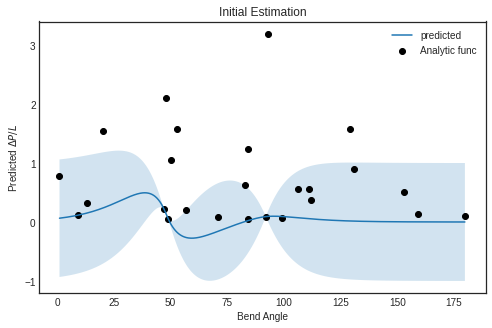

<Figure size 432x288 with 0 Axes>

In [40]:
pred_init, std_init = regressor_3d.predict(x.reshape(-1,3), return_std = True) 

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(8, 5))
    plt.plot(x[:,1], pred_init, label='predicted')
    plt.fill_between(x[:, 1], pred_init-std_init, pred_init+std_init, alpha=0.2)
    plt.scatter(X_raw[:,1], y_raw, c='k', label='Analytic func') # label='CFD calc')
    plt.title('Initial Estimation')
    plt.xlabel('Bend Angle')
    plt.ylabel(r'Predicted $\Delta P/L$')
    plt.legend()
    plt.show()
    plt.savefig('Init_known_func.svg')

In [41]:
N_QUERIES = 12
#performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
    query_index, query_instance = regressor_3d.query(X_pool)

    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool[query_index].reshape(-1, 3), y_pool[query_index].reshape(1, )
    regressor_3d.teach(X=X, y=y)

    # Remove the queried instance from the unlabeled pool.
    X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

    # Calculate and report our model's accuracy.
    model_accuracy = regressor_3d.score(X_raw.reshape(-1,3), y_raw.reshape(-1, 1))
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    # Save our model's performance for plotting.
    #performance_history.append(model_accuracy)

Accuracy after query 1: -0.8151
Accuracy after query 2: -0.6899
Accuracy after query 3: -0.4405
Accuracy after query 4: -0.4114
Accuracy after query 5: -0.3844
Accuracy after query 6: -0.3836
Accuracy after query 7: -0.3782
Accuracy after query 8: -0.3743
Accuracy after query 9: -0.3176
Accuracy after query 10: -0.2719
Accuracy after query 11: -0.2583
Accuracy after query 12: -0.2718


In [42]:
# come up with distributions
D = np.linspace(0.005, 0.1, 1000)
# D_dist = np.random.choice(np.linspace(0.005, 0.1, 1000), size = 1000)
angle = np.linspace(1, 180, 1000, endpoint=False)
vin = np.linspace(0.025, 0.005, 1000)
#vin_dist = np.random.choice(np.linspace(0.01, 1, 1000), size = 1000)
#x = np.hstack((D.reshape(1,-1), angle.reshape(1, -1), vin.reshape(1,-1)))
x = np.column_stack((D, angle, vin))

pred, std = regressor_3d.predict(x.reshape(-1,3), return_std = True) 
pred[:10]

array([0.77961803, 0.7722246 , 0.7632474 , 0.75281263, 0.74104025,
       0.72804429, 0.71393325, 0.69881047, 0.68277447, 0.6659193 ])

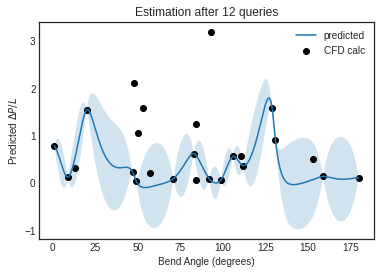

<Figure size 432x288 with 0 Axes>

In [43]:
# plotting after active learning
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(6, 4))
    plt.plot(x[:,1], pred, label='predicted')
    plt.fill_between(x[:, 1], pred-std, pred+std, alpha=0.2)
    plt.scatter(X_raw[:,1], y_raw, c='k', label='CFD calc')
    plt.title(f'Estimation after {N_QUERIES} queries')
    plt.xlabel('Bend Angle (degrees)')
    plt.ylabel(r'Predicted $\Delta P/L$')
    plt.legend()
    plt.show()
    plt.savefig('final_{N_QUERIES}_queries_bendangle.svg')

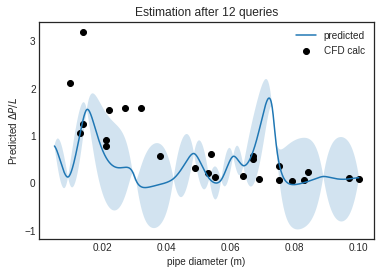

<Figure size 432x288 with 0 Axes>

In [44]:
# plotting after active learning
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(6, 4))
    plt.plot(x[:,0], pred, label='predicted')
    plt.fill_between(x[:, 0], pred-std, pred+std, alpha=0.2)
    plt.scatter(X_raw[:,0], y_raw, c='k', label='CFD calc')
    plt.title(f'Estimation after {N_QUERIES} queries')
    plt.xlabel('pipe diameter (m)')
    plt.ylabel(r'Predicted $\Delta P/L$')
    plt.legend()
    plt.show()
    plt.savefig(f'final_{N_QUERIES}_queries_pipeD.svg')

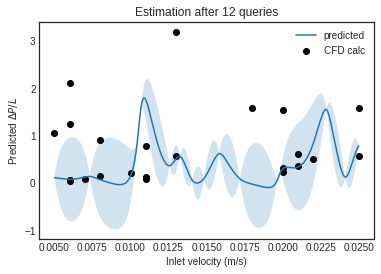

<Figure size 432x288 with 0 Axes>

In [45]:
# plotting after active learning
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(6, 4))
    plt.plot(x[:,2], pred, label='predicted')
    plt.fill_between(x[:, 2], pred-std, pred+std, alpha=0.2)
    plt.scatter(X_raw[:,2], y_raw, c='k', label='CFD calc')
    plt.title(f'Estimation after {N_QUERIES} queries')
    plt.xlabel('Inlet velocity (m/s)')
    plt.ylabel(r'Predicted $\Delta P/L$')
    plt.legend()
    plt.show()
    plt.savefig(f'final_{N_QUERIES}_queries_inletV.svg')

## Test analytic function with noise

In [39]:
X = np.linspace(-np.pi, np.pi, 25)

X_raw = np.column_stack((X, X, X))
y_raw = np.sin(X_raw[:,0]) + np.cos(X_raw[:,1]) + np.sin(X_raw[:,2]) + np.random.random(size=X_raw.shape[0])

n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples, size=5)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

X_train, y_train

(array([[ 0.78539816,  0.78539816,  0.78539816],
        [-0.78539816, -0.78539816, -0.78539816],
        [-1.83259571, -1.83259571, -1.83259571],
        [-2.0943951 , -2.0943951 , -2.0943951 ],
        [-2.61799388, -2.61799388, -2.61799388]]),
 array([ 2.58959936, -0.53032894, -1.40069386, -2.07159817, -1.58376185]))

In [40]:
def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    return np.argmax(std)

kernel = Matern(length_scale=2.0)
regressor = GaussianProcessRegressor(kernel=kernel)

regressor_3d = BayesianOptimizer(
    estimator=regressor,
    query_strategy=max_EI,
    X_training=X_train, y_training=y_train
)

In [41]:
x_1d = np.linspace(-np.pi, np.pi, 1000)
x = np.column_stack((x_1d, x_1d, x_1d))

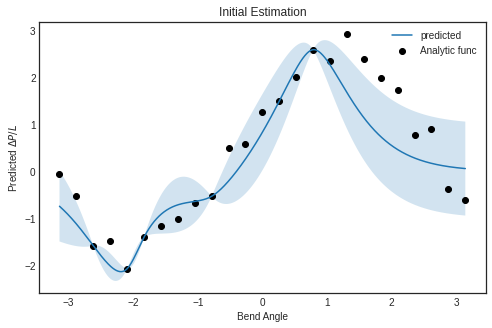

<Figure size 432x288 with 0 Axes>

In [42]:
pred_init, std_init = regressor_3d.predict(x.reshape(-1,3), return_std = True) 

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(8, 5))
    plt.plot(x[:,1], pred_init, label='predicted')
    plt.fill_between(x[:, 1], pred_init-std_init, pred_init+std_init, alpha=0.2)
    plt.scatter(X_raw[:,1], y_raw, c='k', label='Analytic func') # label='CFD calc')
    plt.title('Initial Estimation')
    plt.xlabel('Bend Angle')
    plt.ylabel(r'Predicted $\Delta P/L$')
    plt.legend()
    plt.show()
    plt.savefig('Init_known_func.svg')

In [43]:
N_QUERIES = 10
#performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
    query_index, query_instance = regressor_3d.query(X_pool)

    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool[query_index].reshape(-1, 3), y_pool[query_index].reshape(1, )
    regressor_3d.teach(X=X, y=y)

    # Remove the queried instance from the unlabeled pool.
    X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

    # Calculate and report our model's accuracy.
    model_accuracy = regressor_3d.score(X_raw.reshape(-1,3), y_raw.reshape(-1, 1))
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    # Save our model's performance for plotting.
    #performance_history.append(model_accuracy)

Accuracy after query 1: 0.8467
Accuracy after query 2: 0.8364
Accuracy after query 3: 0.9114
Accuracy after query 4: 0.9019
Accuracy after query 5: 0.9164
Accuracy after query 6: 0.9437
Accuracy after query 7: 0.9630
Accuracy after query 8: 0.9627
Accuracy after query 9: 0.9750
Accuracy after query 10: 0.9701


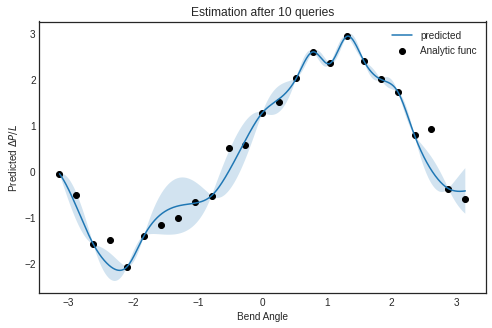

<Figure size 432x288 with 0 Axes>

In [44]:
pred_final, std_final = regressor_3d.predict(x.reshape(-1,3), return_std = True) 

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(8, 5))
    plt.plot(x[:,1], pred_final, label='predicted')
    plt.fill_between(x[:, 1], pred_final-std_final, pred_final+std_final, alpha=0.2)
    plt.scatter(X_raw[:,1], y_raw, c='k', label='Analytic func') # label='CFD calc')
    plt.title(f'Estimation after {N_QUERIES} queries')
    plt.xlabel('Bend Angle')
    plt.ylabel(r'Predicted $\Delta P/L$')
    plt.legend()
    plt.show()
    plt.savefig('Init_known_func.svg')